# Using FLINT

In **Section 1**, several numerical complex integrals are presented.
We shall use the `Python/C` library `FLINT` for numerical evaluations and rigorous bounds.
If you want to use `FLINT` in `Python`, which is a huge library coming with lots of computer arithmetics (including long precision), you have to install the `C` version first to use it.

You need to follow the instructions to install the python library
https://fredrikj.net/python-flint/

which includes first installing FLINT
http://flintlib.org/doc/building.html
(integer and rational arithmetic)

and ARB
https://arblib.org/
(interval and ball arithmetic)

It takes a while to configure and is a bit longer than just `pip install`, but the library is very nicely written, very convenient to use, very fast and has a rich ensemble of operations, including series over integers, rationals, and reals / complex numbers equipped with real/complex interval arithmetic.

In [46]:
import flint
from flint import acb

# Complex integration (several tutorial examples)

Here, there are some examples of rigorous integration bounds using complex trajectories in FLINT / ARB

$$
    I = \left(\int_{-\infty}^{\infty} e^{-x^2}\right)^2 = \pi
$$

In [47]:
### Example of real integration usage
acb.integral(lambda x, _: (-x**2).exp(), -100, 100) ** 2

[3.1415926535898 +/- 7.34e-14]

$$
    I_1 = \left(\int_{-\infty}^{\infty} e^{-(x+i)^2}\right)^2 = \pi
$$

In [48]:
### Example of complex integration usage using ball precision arithmetics
acb.integral(lambda x, _: (-(x+1j)**2).exp(), -100, 100) ** 2

[3.141592653590 +/- 3.11e-13] + [+/- 9.37e-14]j

In [416]:
acb.pi().str(13)

'[3.141592653590 +/- 2.07e-13]'

The precision can be increased to whatever is needed

In [417]:
flint.ctx.dps = 250              # Use 250 digits in decimal representation
acb.integral(lambda x, _: (-x**2).exp(), -100, 100) ** 2

[3.1415926535897932384626433832795028841971693993751058209749445923078164062862089986280348253421170679821480865132823066470938446095505822317253594081284811174502841027019385211055596446229489549303819644288109756659334461284756482337867831652712019 +/- 1.57e-248]

In [418]:
acb.pi()

[3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909 +/- 1.59e-250]

In [420]:
I = acb.integral(lambda x, _: (-x**2).exp(), -100, 100) ** 2
PI = acb.pi()
I - PI

[+/- 1.93e-248]

# Probability of digraph families

### Acyclic digraphs at the center of the transition window

Probability that a digraph $D(n, 1/n)$ is acyclic is
$$
    (2n)^{-1/3} \dfrac{e^{3/2}}{2 \pi i}
    \int_{-i \infty}^{i \infty}
    \dfrac{1}{\mathrm{Ai}(-2^{1/3}s)}
    ds
    \approx
    C n^{-1/3}
$$
In the paper we claim that $C \approx 2.19037$.
FLINT allows to provide provable bounds for integrals on bounded segments.
Note that we replace the right boundary by 20 because the integral is decreasing exponentially fast,
but if we need higher precision, the boundary should be shifted as well.

In [78]:
(
    acb(2)**(-acb(1)/acb(3))
    * acb.exp(acb(3)/acb(2))
    / acb(0,2) / acb.pi()
    * acb.integral(
        lambda s, _:
        flint.acb(1)
        / flint.acb.airy_ai(-flint.acb(2)**(flint.acb(1)/flint.acb(3)) * s),
        acb(0,-20), acb(0,20)
    )    
)

[2.190365954239 +/- 2.67e-13] + [+/- 2.81e-14]j

$$
    C \approx \mathbf{2.19036595423}9
$$

### Elementary digraphs at the center of the transition window

Probability that a digraph $D(n, 1/n)$ is elemenary is
$$
    - \dfrac{2^{-2/3}}{2 \pi i}
    \int_{-i \infty}^{i \infty}
    \dfrac{1}{\mathrm{Ai}'(-2^{1/3}s)}
    ds
    \approx
    C
$$
We claim that $C \approx 0.6997$

In [181]:
(
    -acb(2)**(-acb(2)/acb(3))
    / acb(0,2) / acb.pi()
    * acb.integral(
        lambda s, _:
        flint.acb(1)
        / flint.acb.airy_ai(-flint.acb(2)**(flint.acb(1)/flint.acb(3)) * s, 1),
        acb(0,-20), acb(0,20)
    )    
)

[0.69968786651057262322258722830160452493 +/- 7.79e-39] + [+/- 3.74e-40]j

$$
    C \approx \mathbf{0.699}68786651057262
$$

# Length of the first cycle

We borrow this constant from the paper of 1988, "The first cycles in an evolving graph".

$$
    K = \dfrac{1}{\sqrt{8 \pi} i}
    \int_{-\infty}^{\infty}
    \int_{1-i\infty}^{1+i\infty}
    e^{(\mu+2s)(\mu-s)^2/6}
    \dfrac{ds}{s} d \mu
    \approx
    2.0337
$$

It turns out that the computation of this constant is rather tedious and the description of the computation takes no less than the last five pages of the paper. We provide it for the sake of completeness.

First of all, we need a function which computes complex integral over a piecewise linear contour.

In [84]:
def integral_traj(func, pts, **kwargs):
    """
    Compute complex integral over piecewise linear trajectory.
    Keywords are identical to acb.integral
    """
    return sum([
        acb.integral(func, p, q, **kwargs)
        for p,q in zip(pts[:-1], pts[1:])
    ])

The inner function $f(\mu)$ is unimodular
$$
    f(\mu)
    = \dfrac{1}{\sqrt{8 \pi} i}
    \int_{1-i\infty}^{1+i\infty}
    e^{(\mu+2s)(\mu-s)^2/6}
    \dfrac{ds}{s}
$$

In [347]:
import matplotlib.pyplot as plt
import numpy as np
from cmath import sqrt, pi
def lplot(fun, l, r, npts=100, **kwargs):
    """
    Lambda-function plot, with boundaries and number of points
    """
    xargs = np.linspace(l,r,npts)
    plt.plot(xargs, list(map(fun, xargs)), **kwargs)

In [236]:
def acb2float(r):
    """
    Convert FLINT ACB to float (for plotting purposes)
    """
    re = float(r.real.mid().str(8, radius=False))
    return float(re)

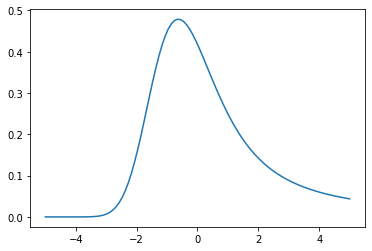

In [350]:
flint.ctx.dps = 15    # the default precision used by FLINT
infty = 40

## We use a different trajectory which gives a better convergent expression:
## instead of running over a contour [1-i*infty, 1+i*infty]
## we use a piecewise contour with 4 points
lplot(lambda mu: acb2float(
        acb(1)/ acb.sqrt(acb(8) * acb.pi()) / acb(0,1)
        * acb.exp(acb(mu)**3/6)
        * integral_traj(
            lambda s, _:
            flint.acb.exp(-acb(mu)*s**2/2 + s**3/3) / s,
            [infty*(1 - 1.5j), 1 - 1j, 1+1j, infty*(1+1.5j)]
    )), -5, 5)

CPU times: user 17 s, sys: 84.1 ms, total: 17.1 s
Wall time: 17.2 s


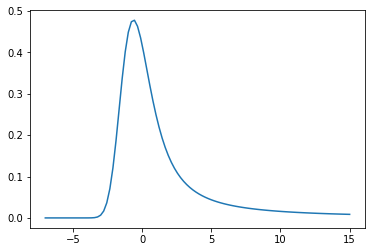

In [351]:
%%time
# In order to plot beyond mu=5, we need to increase the context precision
flint.ctx.dps=270
infty = 40

lplot(lambda mu: acb2float(
        acb(1)/ acb.sqrt(acb(8) * acb.pi()) / acb(0,1)
        * acb.exp(acb(mu)**3/6)
        * integral_traj(
            lambda s, _:
            flint.acb.exp(-acb(mu)*s**2/2 + s**3/3) / s,
            [infty*(1 - 1.5j), 1 - 1j, 1+1j, infty*(1+1.5j)]
    )), -7, 15)

Taking the integral from $-7$ to $5$ can be done very quickly, but if we extend the upper limit, we need to increase heavily the required digit precision to dozens and even hunderds.

In [334]:
%%time
flint.ctx.dps=15
infty = 40
1 / sqrt(8 * pi) / 1j * acb.integral(
    lambda mu, _:
    integral_traj(
        lambda s, _:
        flint.acb.exp((mu + 2*s) * (mu - s)**2/6) / s,
        [infty*(1 - 1.5j), 1 - 1j, 1+1j, infty*(1+1.5j)]
    ),
    -7, 5
)

CPU times: user 1min, sys: 241 ms, total: 1min
Wall time: 1min 1s


[1.58788 +/- 5.25e-6] + [+/- 6.98e-7]j

Note that the paper provides, using an asymptotic approximation, an estimate for the completion of the integral
$$
    \int_5^\infty f(\mu) d \mu \approx
    0.4458165587745
$$

In [352]:
int_5_infty = 0.4458165587745

In [353]:
1.58788 + int_5_infty

2.0336965587745

We can try to improve this approximation (a little bit) and use the asymptotic expansion for the integral with a higher boundary instead

In [180]:
%%time
flint.ctx.dps=40
infty = 40
1 / sqrt(8 * pi) / 1j * acb.integral(
    lambda mu, _:
    integral_traj(
        lambda s, _:
        flint.acb.exp((mu + 2*s) * (mu - s)**2/6) / s,
        [infty*(1 - 1.5j), 1 - 1j, 1+1j, infty*(1+1.5j)]
    ),
    -7, 8
)

CPU times: user 6min 3s, sys: 500 ms, total: 6min 4s
Wall time: 6min 5s


[1.68 +/- 2.62e-3] + [+/- 2.20e-3]j

Taking the integral until $\mu = 10$ requires 80 digits of precision arithmetics and takes around half an hour on a personal computer. By doing that, we have six or maybe seven digits of the final answer.

In [193]:
%%time
flint.ctx.dps=80
infty = 40
1 / sqrt(8 * pi) / 1j * acb.integral(
    lambda mu, _:
    integral_traj(
        lambda s, _:
        flint.acb.exp((mu + 2*s) * (mu - s)**2/6) / s,
        [infty*(1 - 1.5j), 1 - 1j, 1+1j, infty*(1+1.5j)]
    ),
    -7, 10
)

#### CPU times: user 19min 8s, sys: 2.73 s, total: 19min 11s
#### Wall time: 23min 34s
#### answer:
####
#### [1.717592 +/- 6.11e-7] + [+/- 2.53e-7]j

CPU times: user 19min 8s, sys: 2.73 s, total: 19min 11s
Wall time: 23min 34s


[1.717592 +/- 6.11e-7] + [+/- 2.53e-7]j

In order to complete this integral, we use an asymptotic approximaiton from the paper.
$$
    \int_{\mu}^\infty f(\mu) d \mu \sim
    \dfrac{1}{\sqrt{\mu}} \left(
        1
        - \dfrac{c_1}{7 \mu^3}
        + \dfrac{c_2}{13 \mu^6}
        - \dfrac{c_3}{19 \mu^9}
        + \ldots
    \right)
$$
where
$$
    c_n = \sum_{k=0}^{2n} \dfrac{(2n+2k)!}{2^{n+k}3^k (n+k)! k!},
$$
and
$$
    c_1 = \dfrac{17}{6}
    \quad \text{and} \quad
    c_2 = \dfrac{1807}{72}
$$

In [342]:
def c_n(n):
    return sum([
        flint.fmpq(1)
        * flint.fmpz.fac_ui(2*n+2*k)
        / flint.fmpz(2)**(n+k)
        / flint.fmpz(3)**k
        / flint.fmpz.fac_ui(n+k)
        / flint.fmpz.fac_ui(k)
        for k in range(2*n+1)
    ])

In [355]:
[
    c_n(n)
    for n in range(10)
]

[17/6,
 1801/72,
 481265/1296,
 240940945/31104,
 38846522365/186624,
 45982534827845/6718464,
 10728993407487355/40310784,
 23120114254624061675/1934917632,
 63547254659956182190075/104485552128]

In [376]:
def divergent_approximation(mu, order):
    """
    Taylor series approximation for \int_mu^\infty f(mu) d mu"""
    return acb(1) / acb.sqrt(acb(mu)) * sum(
        (-acb(1))**k * c_n(k)
        / (acb(6)*acb(k)+acb(1))
        / acb(mu)**(3*k)
        for k in range(order)
    )

In [384]:
[
    divergent_approximation(5, order).mid().str(25)
    for order in range(1, 30)
]

['[0.4472135954999579392818347 +/- 3.38e-26]',
 '[0.4457654752859580754784459 +/- 3.56e-26]',
 '[0.4458205475379577626065585 +/- 2.26e-26]',
 '[0.4458160723566496240800837 +/- 4.93e-28]',
 '[0.4458166399395503864576355 +/- 7.27e-27]',
 '[0.4458165415411833676200334 +/- 4.78e-26]',
 '[0.4458165632270164065191222 +/- 1.16e-27]',
 '[0.4458165574218565305237210 +/- 3.68e-26]',
 '[0.4458165592514993160139767 +/- 7.58e-27]',
 '[0.4458165585877520543428509 +/- 1.26e-26]',
 '[0.4458165588601905953776875 +/- 3.32e-26]',
 '[0.4458165587353604089447594 +/- 4.58e-26]',
 '[0.4458165587985220885975317 +/- 4.66e-26]',
 '[0.4458165587635431499636711 +/- 8.64e-27]',
 '[0.4458165587845880862200657 +/- 2.32e-26]',
 '[0.4458165587709191227145959 +/- 2.39e-26]',
 '[0.4458165587804518262630533 +/- 3.75e-26]',
 '[0.4458165587733471370172431 +/- 4.20e-26]',
 '[0.4458165587789826247778263 +/- 2.87e-26]',
 '[0.4458165587742424633394295 +/- 7.90e-27]',
 '[0.4458165587784567311407945 +/- 3.32e-26]',
 '[0.44581655

Using the optimal truncation rule, the best approximation is as specified in the paper.

In [378]:
%%time
flint.ctx.dps=80
infty = 40
1 / sqrt(8 * pi) / 1j * acb.integral(
    lambda mu, _:
    integral_traj(
        lambda s, _:
        flint.acb.exp((mu + 2*s) * (mu - s)**2/6) / s,
        [infty*(1 - 1.5j), 1 - 1j, 1+1j, infty*(1+1.5j)]
    ),
    -7, 5
)

#### CPU times: user 8min 23s, sys: 1.51 s, total: 8min 25s
#### Wall time: 9min 2s
###
#### [1.5878754552874551591193508992954393346617876633230621007862647029179318 +/- 1.45e-71] + [+/- 7.31e-72]j

CPU times: user 8min 23s, sys: 1.51 s, total: 8min 25s
Wall time: 9min 2s


[1.5878754552874551591193508992954393346617876633230621007862647029179318 +/- 1.45e-71] + [+/- 7.31e-72]j

Here is the updated version of the constant. It can be further improved using an integration until mu = 10 as above with higher precision.

In [379]:
0.44581655877 + 1.587875455287455

2.033692014057455

## High-precision computation for $\mu = 10$

#### Tail integral

We compute the divergent approximation for the tail of the integral

In [474]:
[
    divergent_approximation(10, order).mid().str(80)
    for order in range(1, 200)
]

['[0.31622776601683793319988935444327185337195551393252168268575048527925944386392382 +/- 2.14e-81]',
 '[0.31609976906392635594121320875218767190749543670069185248085387198759879123188366 +/- 2.50e-81]',
 '[0.31610037753209579645950134229997330474147826030312838289917707394980390655908281 +/- 3.36e-81]',
 '[0.31610037135156640188130495172798052671430036422393042916562250857627778172466126 +/- 3.52e-81]',
 '[0.31610037144955021975596521090625755211939536067884349246920074990767549257521856 +/- 1.17e-82]',
 '[0.31610037144742686304891251330718135581665070587944199265592002318731116514832565 +/- 3.30e-81]',
 '[0.31610037144748535837818758662909695245047745074455695227587545059746993802794337 +/- 4.55e-81]',
 '[0.31610037144748340102463658584062585039976838064378246976370100661605819808544128 +/- 4.55e-81]',
 '[0.31610037144748347813831389494861895778019152578955287386114505066106248141432140 +/- 6.02e-82]',
 '[0.31610037144748347464145698405190910311935209571464699712302163770804660217689

In [499]:
## Here is the best available approximation from the divergent series
tail_center = flint.arb("0.3161003714474834748112021683538119614011102716646792748332559406568471939035")
## We take a conservative bound
tail_error  = flint.arb("0.0000000000000000000000000000000000000000000000000000000000000000000000000004")
tail_integral = acb(flint.arb(tail_center, tail_error))
tail_integral

[0.316100371447483474811202168353811961401110271664679274833255940656847193903 +/- 9.01e-76]

In [502]:
#################################### HERE ##########################################

In [412]:
mid_integral = acb("1.717591642616415524354275066554789140887439914867431405431068002253 +/- 6.48e-67")
mid_integral

[1.717591642616415524354275066554789140887439914867431405431068002253 +/- 6.49e-67]

In [413]:
mid_integral + tail_integral

[2.033692014063898999165477234908601102288550186532110680264323942910 +/- 8.01e-67]

#### As predicted, previous approximation had 10 valid digits (which corresponds to the best approximation of the divergent series having 11 digits, but with an additional flip in the last digit due to summation)
$$
    C_5 \approx \mathbf{2.0336920140}57455
$$

#### The new approximation is better and can be computed in around an hour of computation on a personal computer (excluding the last two digits to avoid possible flips from summation)
$$
    C_{10} \approx \mathbf{\underline{2.0336920140}638989991654772349086011022885501865321106802643239429}10
$$

### Estimating the bounds for the middle integral

We can increase the limit of integration for the middle part for the inner function ($\infty = 100$) and for the outer integral (look at the value of the function at the lower end) to see whether any of the final digits change.

In [503]:
# In order to plot beyond mu=5, we need to increase the context precision
flint.ctx.dps=140
infty = 40

(lambda mu: acb2float(
        acb(1)/ acb.sqrt(acb(8) * acb.pi()) / acb(0,1)
        * acb.exp(acb(mu)**3/6)
        * integral_traj(
            lambda s, _:
            flint.acb.exp(-acb(mu)*s**2/2 + s**3/3) / s,
            [infty*(1 - 1.5j), 1 - 1j, 1+1j, infty*(1+1.5j)]
    )))(-7)

9.1963454e-26

**As we observe, in order to get 60+ digits, the left limit of 7 is not sufficient.**

In [423]:
(lambda mu: acb2float(
        acb(1)/ acb.sqrt(acb(8) * acb.pi()) / acb(0,1)
        * acb.exp(acb(mu)**3/6)
        * integral_traj(
            lambda s, _:
            flint.acb.exp(-acb(mu)*s**2/2 + s**3/3) / s,
            [infty*(1 - 1.5j), 1 - 1j, 1+1j, infty*(1+1.5j)]
    )))(-10)

2.5760563e-73

In [429]:
(lambda mu: 
        acb(1)/ acb.sqrt(acb(8) * acb.pi()) / acb(0,1)
        * acb.exp(acb(mu)**3/6)
        * integral_traj(
            lambda s, _:
            flint.acb.exp(-acb(mu)*s**2/2 + s**3/3) / s,
            [infty*(1 - 1.5j), 1 - 1j, 1+1j, infty*(1+1.5j)]
    ))(-12)

[5.2171668753135236021827281079110794825101695998254454333405903252218352290366608262579975874412768659262944108664611100126779828903056700e-126 +/- 4.87e-263] + [+/- 6.87e-263]j

**Therefore, we take the left limit to -12 and it is safe (for given infinity)**.

**Now, let us estimate the value of infinity required for the inner integral**

In [462]:
C1 = (lambda mu, infty: 
        acb(1)/ acb.sqrt(acb(8) * acb.pi()) / acb(0,1)
        * acb.exp(acb(mu)**3/6)
        * integral_traj(
            lambda s, _:
            flint.acb.exp(-acb(mu)*s**2/2 + s**3/3) / s,
            [infty*(1 - 1.5j), 1 - 1j, 1+1j, infty*(1+1.5j)]
    ))
D = lambda mu, infty1, infty2: C1(mu, infty1) - C1(mu, infty2)

The function $ D $ computes how many correct digits are expected if we change the inner integration limit of
$$
    f(\mu)
    = \dfrac{1}{\sqrt{8 \pi} i}
    \int_{\Gamma}
    e^{(\mu+2s)(\mu-s)^2/6}
    \dfrac{ds}{s}
$$
and also as the argument $\mu$ of this function

In [463]:
def arb2float(r):
    """
    Convert FLINT ARB to float (for plotting purposes)
    """
    return float(r.mid().str(8, radius=False))

([<matplotlib.axis.YTick at 0x11cac8dc0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

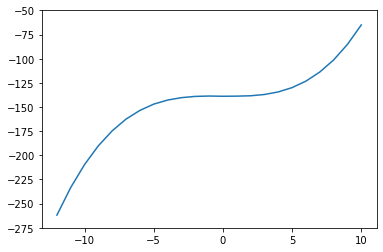

In [468]:
plt.plot(range(-12, 11), [
    arb2float(                                     ## Convert to python float for plotting
        flint.arb.log(D(n, 60, 80).abs_upper())    ## Upper bound for the absolute value
        /
        flint.arb.log(flint.arb(10))               ## Logarithm is base 10
    )
    for n in range(-12, 11)
])
plt.yticks(ticks=range(-275, -49, 25))

In [473]:
D(10, 40, 100)

[+/- 6.04e-66] + [+/- 6.03e-66]j

The maximal error is happening on the right end of the integration interval.
Since the length of the integration for which this error persists can be bounded by 5,
we are safe to throw the last two digits corresponding to $10^{-65}$. It cannot be improved by extending the limit of integration unless we use higher digit precision than `flint.ctx.dps=140`.

In [507]:
## This is a very conservative error bound 
err = flint.arb(0, "1e-63")
err

[+/- 1.01e-63]

#### Computing the middle integral and assembling pieces together

In [508]:
%%time
flint.ctx.dps=140
infty = 60
mid_integral = 1 / sqrt(8 * pi) / 1j * acb.integral(
    lambda mu, _:
    integral_traj(
        lambda s, _:
        flint.acb.exp((mu + 2*s) * (mu - s)**2/6) / s,
        [infty*(1 - 1.5j), 1 - 1j, 1+1j, infty*(1+1.5j)]
    ),
    -12, 10
)
mid_integral

CPU times: user 46min 27s, sys: 14.3 s, total: 46min 41s
Wall time: 48min 16s


[1.717591642616415524354275070266294434865070980650657747597005148875 +/- 5.75e-67] + [+/- 3.07e-67]j

In [509]:
mid_integral + tail_integral + err

[2.03369201406389899916547723862010639626618125231533702243026109 +/- 1.47e-63] + [+/- 3.07e-67]j

$$
    K = 2.033692014063898999165477238620106396266181252315337022430261...
$$